# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

### Overview
In this notebook we will do the following:
- perform an initial analysis on the Sparkify dataset
- transform the dataset into one that is suitable to be used in machine learning
- test different machine learning models and score them

### Problem statement
Sparkify is an audio streaming and media services provider that allows users to stream millions of songs. Users may choose to be a paid member of make use of the free membership. Users can also cancel their paid membership at any time. This is referred to as churn. The aim of this project is to analyse page visits (events) and be able to predict when a user may cancel their membership.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import datetime
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import udf
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col,countDistinct
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType, DateType,StringType
from pyspark.sql import types as t
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, StringIndexer, Normalizer, RegexTokenizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier,DecisionTreeClassifier,LogisticRegression,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve


In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#Load dataset
path = "mini_sparkify_event_data.json"
sparkify_df = spark.read.json(path)

In [4]:
#View the schema
sparkify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
#View first 5 rows
sparkify_df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [6]:
#Number of rows Before doing any transformations
sparkify_df.count()


286500

In [7]:
#Check for duplicates
sparkify_df.groupBy(sparkify_df.columns)\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

+----------+
|sum(count)|
+----------+
|      null|
+----------+



In [8]:
#Check for missing values
sparkify_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sparkify_df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
#Replace null values in length with 0
sparkify_df=sparkify_df.na.fill(value=0,subset=["length"])

In [10]:
#Cast userID to integer datatype
sparkify_df = sparkify_df.withColumn("userId", sparkify_df ["userId"].cast(IntegerType()))

In [11]:
#Drop records without userids or sessionids
sparkify_df = sparkify_df.dropna(how = "any", subset = ["userId", "sessionId"])

In [12]:
#Drop culumns not needed for now
sparkify_df = sparkify_df.drop(*["song","firstName", "lastName"])  

In [13]:
sparkify_df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|     2|
|     3|
|     4|
|     5|
|     6|
|     7|
|     8|
|     9|
|    10|
|    11|
|    12|
|    13|
|    14|
|    15|
|    16|
|    17|
|    18|
|    19|
|    20|
|    21|
+------+
only showing top 20 rows



In [14]:
#Number of rows after doing some transformations
sparkify_df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Explore the data

In [15]:
#For a seleced set of columns, lets explore the unique value counts
columns=["auth",
"gender",
"level",
"location",
"method",
"page",
"userAgent"]

for c in columns:
    sparkify_df.groupBy(c).count().orderBy("count").show()
    

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+

+------+------+
|gender| count|
+------+------+
|     M|123576|
|     F|154578|
+------+------+

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Scranton--Wilkes-...|    6|
|  Corpus Christi, TX|   11|
|          Albany, OR|   23|
|   Memphis, TN-MS-AR|   62|
|Deltona-Daytona B...|   73|
|Birmingham-Hoover...|   75|
|Cincinnati, OH-KY-IN|   88|
|       Duluth, MN-WI|  107|
|  Port St. Lucie, FL|  117|
|Portland-Vancouve...|  119|
|      Montgomery, AL|  125|
|Omaha-Council Blu...|  187|
|          Monroe, LA|  216|
|Santa Maria-Santa...|  218|
|Seattle-Tacoma-Be...|  246|
|Virginia Beach-No...|  246|
|         Bozeman, MT|  254|
|          Dayton, OH|  259|
|          Muncie, IN|  292|
|         Pontiac, IL|  315|
+--------------------+-----+
o

In [16]:
#Explore ts and registration
columns=["ts",
"registration"]
for c in columns:
    sparkify_df.groupBy(c).count().orderBy("count").show(10)

+-------------+-----+
|           ts|count|
+-------------+-----+
|1538360520000|    1|
|1538368903000|    1|
|1538380099000|    1|
|1538380879000|    1|
|1538390386000|    1|
|1538399222000|    1|
|1538402692000|    1|
|1538405492000|    1|
|1538411816000|    1|
|1538420258000|    1|
+-------------+-----+
only showing top 10 rows

+-------------+-----+
| registration|count|
+-------------+-----+
|1532433959000|    6|
|1543247354000|    6|
|1533157139000|   11|
|1537970819000|   23|
|1530789251000|   35|
|1536343087000|   36|
|1537681013000|   40|
|1536126401000|   44|
|1537964483000|   44|
|1533995214000|   45|
+-------------+-----+
only showing top 10 rows



In [17]:
# convert ts and registration unix timestamps to datetime columns
get_date_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
sparkify_df = sparkify_df.withColumn("event_ts", get_date_time("ts"))
sparkify_df = sparkify_df.withColumn("registration_ts", get_date_time("registration"))



In [18]:
#Check updated schema
sparkify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- event_ts: string (nullable = true)
 |-- registration_ts: string (nullable = true)



In [19]:
#Check our results
columns=["event_ts",
"registration_ts"]
for c in columns:
    sparkify_df.groupBy(c).count().orderBy("count").show(10)

+-------------------+-----+
|           event_ts|count|
+-------------------+-----+
|2018-10-01 19:11:55|    1|
|2018-10-02 16:29:17|    1|
|2018-10-01 19:58:34|    1|
|2018-10-01 05:48:39|    1|
|2018-10-01 20:30:22|    1|
|2018-10-01 09:52:42|    1|
|2018-10-02 01:48:17|    1|
|2018-10-01 10:58:42|    1|
|2018-10-02 03:52:00|    1|
|2018-10-01 12:54:27|    1|
+-------------------+-----+
only showing top 10 rows

+-------------------+-----+
|    registration_ts|count|
+-------------------+-----+
|2018-07-24 12:05:59|    6|
|2018-11-26 15:49:14|    6|
|2018-08-01 20:58:59|   11|
|2018-09-26 14:06:59|   23|
|2018-07-05 11:14:11|   35|
|2018-09-07 17:58:07|   36|
|2018-09-23 05:36:53|   40|
|2018-09-26 12:21:23|   44|
|2018-09-05 05:46:41|   44|
|2018-08-11 13:46:54|   45|
+-------------------+-----+
only showing top 10 rows



In [20]:
#Lets understand the date range of our events
max_event_date = sparkify_df.agg({"event_ts": "max"}).collect()[0]
min_event_date = sparkify_df.agg({"event_ts": "min"}).collect()[0]
print("First event in our dataset: ",min_event_date)
print("Last event in our dataset: ",max_event_date)

First event in our dataset:  Row(min(event_ts)='2018-10-01 00:01:57')
Last event in our dataset:  Row(max(event_ts)='2018-12-03 01:11:16')


In [21]:
#How many unique users do we have before operations?
sparkify_df.select("userId").dropDuplicates().count()

225

### Define churn

In [22]:
#Column with boolean value for users that cancelled (churn)
get_churned_users=udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
sparkify_df=sparkify_df.withColumn("churn",get_churned_users("page"))

#Column with boolean value for users that downgraded
get_downgraded_users=udf(lambda x: 1 if x=="Submit Downgrade" else 0, IntegerType())
sparkify_df=sparkify_df.withColumn("downgraded",get_downgraded_users("page"))

In [23]:
#Check our results
columns=["churn",
"downgraded"]
for c in columns:
    sparkify_df.groupBy(c).count().orderBy("count").show(10)

+-----+------+
|churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+

+----------+------+
|downgraded| count|
+----------+------+
|         1|    63|
|         0|278091|
+----------+------+



In [24]:
#Find the downgragded and churned users using window aggregate functions
downgrade_users_window=Window.partitionBy("UserId")
churn_users_window=Window.partitionBy("UserId")
sparkify_df=sparkify_df.withColumn("churn_user",F.max("churn").over(churn_users_window))
sparkify_df=sparkify_df.withColumn("downgraded_user",F.max("downgraded").over(downgrade_users_window))


In [25]:
sparkify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- event_ts: string (nullable = true)
 |-- registration_ts: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- churn_user: integer (nullable = true)
 |-- downgraded_user: integer (nullable = true)



In [26]:
#Drop some extra unneeded columns
sparkify_df = sparkify_df.drop(*["ts","registration","churn", "downgraded"])  

In [27]:
#View our results so far for subset of users
sparkify_df.select(["userId","gender","registration_ts","churn_user","downgraded_user"]).dropDuplicates(subset=["userId"]).show(20)

+------+------+-------------------+----------+---------------+
|userId|gender|    registration_ts|churn_user|downgraded_user|
+------+------+-------------------+----------+---------------+
|   148|     M|2018-09-21 11:57:56|         0|              0|
|    85|     M|2018-08-13 04:18:18|         0|              1|
|   137|     M|2018-07-24 16:44:26|         0|              0|
|    65|     M|2018-09-19 08:53:31|         0|              0|
|200001|     M|2018-09-29 21:06:20|         1|              0|
|    53|     M|2018-09-27 12:09:24|         1|              0|
|   133|     M|2018-09-05 05:46:41|         0|              0|
|100003|     F|2018-09-18 22:22:24|         1|              0|
|200021|     F|2018-08-23 14:01:54|         1|              0|
|    78|     F|2018-09-30 10:47:35|         0|              0|
|100007|     F|2018-08-06 02:26:59|         1|              0|
|300011|     F|2018-09-30 19:46:11|         0|              1|
|   108|     F|2018-09-29 10:12:43|         0|         

### Exploratory data analysis to observe the behavior for users who stayed vs users who churned

In [28]:
#First lets look at the page events of churned users vs non-churned users

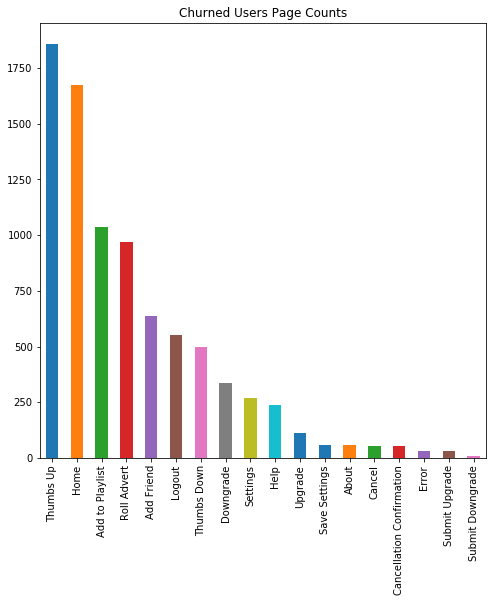

In [29]:
sparkify_df.filter((F.col("churn_user")==1)&(F.col("page")!="NextSong")).toPandas()\
                    .page.value_counts().plot(kind='bar',figsize=(8,8));
plt.title("Churned Users Page Counts")
plt.show()

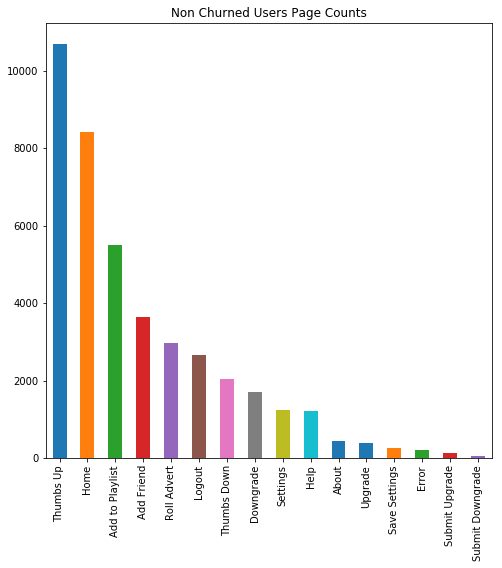

In [30]:
sparkify_df.filter((F.col("churn_user")==0)&(F.col("page")!="NextSong")).toPandas()\
                    .page.value_counts().plot(kind='bar',figsize=(8,8));
plt.title("Non Churned Users Page Counts")
plt.show()

In [31]:
#Observation: We can see that non-churned users were more active in adding their friends

In [32]:
#Now we can explore some attributes around users
sparkify_users=sparkify_df.select(["userId", "gender","downgraded_user","location","churn_user"]).dropDuplicates(subset = ['userId'])

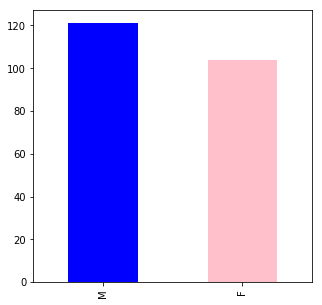

In [33]:
sparkify_users.toPandas()\
                    .gender.value_counts().plot(kind='bar',figsize=(5,5),color=["blue","pink"]);

In [34]:
# Observe our dataset contains more male than female users

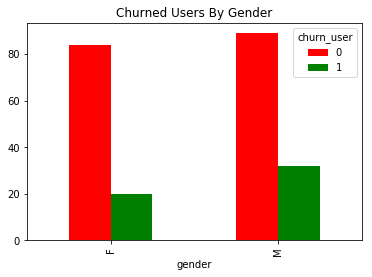

In [35]:
sparkify_users_pd=sparkify_users.toPandas()
pd.crosstab(sparkify_users_pd["gender"],sparkify_users_pd["churn_user"]).plot\
            .bar(color=["red","green"], title="Churned Users By Gender");

In [36]:
# The churned users by gender does not give us any immediate insights

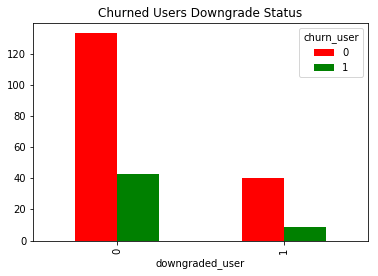

In [37]:
pd.crosstab(sparkify_users_pd["downgraded_user"],sparkify_users_pd["churn_user"]).plot\
            .bar(color=["red","green"], title="Churned Users Downgrade Status");

In [38]:
#Observe that most users are on the paid plan and didn't churn. But still there are even users on the free plan the did churn

In [39]:
#Total Number of songs listened to per user, using the "NextSong" page event
sparkify_df.filter((F.col("page")=="NextSong")&(F.col("churn_user")==0)).groupBy(["userId","churn_user"]).count().show()

+------+----------+-----+
|userId|churn_user|count|
+------+----------+-----+
|   148|         0|  398|
|    85|         0| 3616|
|   137|         0|  154|
|    65|         0| 2113|
|   133|         0|   32|
|    78|         0|  254|
|300011|         0| 4619|
|   108|         0|  633|
|   155|         0|  820|
|    34|         0|   53|
|   115|         0| 1737|
|   126|         0| 2577|
|    81|         0| 1974|
|300010|         0|  263|
|300017|         0| 3632|
|    76|         0|  212|
|    26|         0|  255|
|    27|         0|  220|
|    44|         0|  429|
|200014|         0|  747|
+------+----------+-----+
only showing top 20 rows



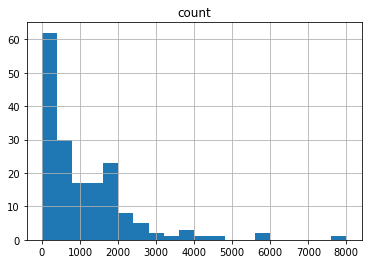

In [40]:
#Total songs per user - for non-churned users
sparkify_df.filter((F.col("page")=="NextSong")&(F.col("churn_user")==0)).groupBy(["userId","churn_user"]).count()\
.toPandas().hist(column="count", bins=20);

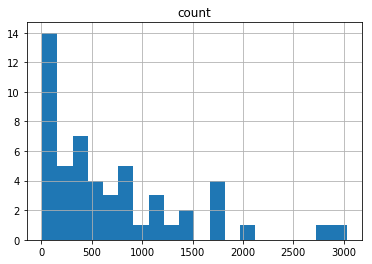

In [41]:
#Total songs per user- for churned users
sparkify_df.filter((F.col("page")=="NextSong")&(F.col("churn_user")==1)).groupBy(["userId","churn_user"]).count()\
.toPandas().hist(column="count", bins=20);

In [42]:
#We can immediatly observe that non-churned users listened to a greater total number of songs per user. 
#This coud be related to how long they have been using the platform, which we will explore in our features

In [43]:
#Total Number of songs per user, per session, churned users
songs_per_session_df=sparkify_df.filter(F.col("page")=="NextSong")\
    .groupBy(["userId","churn_user","sessionId"]).count()

In [44]:
songs_per_session_df.show(10)

+------+----------+---------+-----+
|userId|churn_user|sessionId|count|
+------+----------+---------+-----+
|   148|         0|      147|    8|
|   148|         0|      531|   17|
|   148|         0|      680|   13|
|   148|         0|      736|  129|
|   148|         0|      896|   79|
|   148|         0|      940|   31|
|   148|         0|     1127|    6|
|   148|         0|     1274|   46|
|   148|         0|     1731|   17|
|   148|         0|     1734|   24|
+------+----------+---------+-----+
only showing top 10 rows



In [45]:
#Average number of songs per session, per user

In [46]:
avg_songs_per_session_df=songs_per_session_df.groupBy(["userId","churn_user"]).agg({"count":"avg"})
#Number of songs should be a whole number
avg_songs_per_session_df = avg_songs_per_session_df\
                        .withColumn("avg_songs_per_session",F.round(avg_songs_per_session_df["avg(count)"]).cast(IntegerType()))

avg_songs_per_session_df.show()

+------+----------+------------------+---------------------+
|userId|churn_user|        avg(count)|avg_songs_per_session|
+------+----------+------------------+---------------------+
|   148|         0|33.166666666666664|                   33|
|    85|         0|              90.4|                   90|
|   137|         0|51.333333333333336|                   51|
|    65|         0| 96.04545454545455|                   96|
|200001|         1|             28.75|                   29|
|    53|         1| 83.14285714285714|                   83|
|   133|         0|              32.0|                   32|
|100003|         1|              25.5|                   26|
|200021|         1|           76.6875|                   77|
|    78|         0| 28.22222222222222|                   28|
|100007|         1|              47.0|                   47|
|300011|         0|63.273972602739725|                   63|
|   108|         0|             105.5|                  106|
|   155|         0|136.6

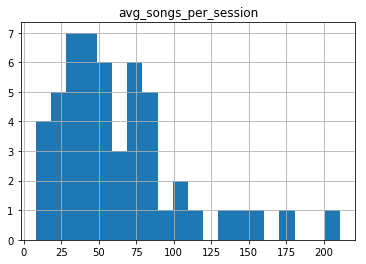

In [47]:
#Average songs per user- for churned users
avg_songs_per_session_df.filter(F.col("churn_user")==1).toPandas()\
                        .hist(column="avg_songs_per_session", bins=20);

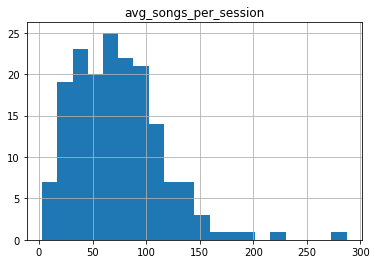

In [48]:
#Average songs per user- for non-churned users
avg_songs_per_session_df.filter(F.col("churn_user")==0).toPandas()\
                        .hist(column="avg_songs_per_session", bins=20);

In [49]:
#As a final observation, we can see that in general, non-churned users made greater use of the platform
#and listened to more songs

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [50]:
#Feature 1: user gender
gender_feat_df=sparkify_df.select(["userId","gender"]).dropDuplicates(subset=["userId"])\
                .replace(["F","M"],["1","0"])
gender_feat_df.show()

+------+------+
|userId|gender|
+------+------+
|   148|     0|
|    85|     0|
|   137|     0|
|    65|     0|
|200001|     0|
|    53|     0|
|   133|     0|
|100003|     1|
|200021|     1|
|    78|     1|
|100007|     1|
|300011|     1|
|   108|     1|
|   155|     1|
|    34|     0|
|   101|     0|
|   115|     1|
|   126|     0|
|    81|     0|
|100005|     0|
+------+------+
only showing top 20 rows



In [51]:
#Feature 2: total time spent on the platform (sum of session length)
total_len_feat_df=sparkify_df.groupBy("userId")\
                .agg(F.sum("length")).withColumnRenamed("sum(length)", "total_session_length")
total_len_feat_df.show()

+------+--------------------+
|userId|total_session_length|
+------+--------------------+
|   148|   97796.86112999993|
|   137|   38385.87630999999|
|    85|    909088.972689999|
|    65|   529357.9054199992|
|200001|  30793.221329999982|
|    53|   431131.0810900001|
|   133|   8029.164280000002|
|100003|  12306.419320000003|
|200021|  300718.15056000033|
|    78|   62494.42193999997|
|100007|  104495.32492000007|
|300011|  1149641.2196899974|
|   108|   156542.7986499999|
|   155|         198779.2919|
|    34|  12931.084549999996|
|   101|   447464.0146699989|
|   126|   648839.6086000006|
|   115|  431447.61070999934|
|    81|        497847.84291|
|100005|   37037.12201000001|
+------+--------------------+
only showing top 20 rows



In [52]:
# Feature 3: average length of session
avg_session_len_feat_df=sparkify_df.groupBy(["userId"]).agg({"length":"avg"})\
                        .withColumnRenamed("avg(length)", "avg_session_length")

avg_session_len_feat_df.show()

+------+------------------+
|userId|avg_session_length|
+------+------------------+
|   148|188.79702920849408|
|   137|183.66447995215307|
|    85|208.02951320137277|
|    65|  208.080937665094|
|200001|194.89380588607582|
|    53|208.88133773740316|
|   133| 182.4810063636364|
|100003| 157.7746066666667|
|200021|200.21181794940102|
|    78|192.88401833333324|
|100007|200.95254792307705|
|300011| 200.5654605181433|
|   108| 204.8989511125653|
|   155| 198.3825268463074|
|    34|177.13814452054788|
|   101|208.21964386691434|
|   126|209.16815235332064|
|   115|207.82640207610757|
|    81|  213.211067627409|
|100005|171.46815745370372|
+------+------------------+
only showing top 20 rows



In [53]:
# Feature 4: total number of songs listened to per user
total_songs_feat_df=sparkify_df.filter(F.col("page")=="NextSong")\
                        .groupBy("userId").count()\
                        .withColumnRenamed("count", "total_songs")
total_songs_feat_df.show()

+------+-----------+
|userId|total_songs|
+------+-----------+
|   148|        398|
|   137|        154|
|    85|       3616|
|    65|       2113|
|200001|        115|
|    53|       1746|
|   133|         32|
|100003|         51|
|200021|       1227|
|    78|        254|
|100007|        423|
|300011|       4619|
|   108|        633|
|   155|        820|
|    34|         53|
|   101|       1797|
|   126|       2577|
|   115|       1737|
|    81|       1974|
|100005|        154|
+------+-----------+
only showing top 20 rows



In [54]:
# Feature 5: average number of songs listened to per user per session
#Use the dataframe created in our exploration
avg_songs_per_session_feat_df=avg_songs_per_session_df.select("userId","avg_songs_per_session")
avg_songs_per_session_feat_df.show()

+------+---------------------+
|userId|avg_songs_per_session|
+------+---------------------+
|   148|                   33|
|    85|                   90|
|   137|                   51|
|    65|                   96|
|200001|                   29|
|    53|                   83|
|   133|                   32|
|100003|                   26|
|200021|                   77|
|    78|                   28|
|100007|                   47|
|300011|                   63|
|   108|                  106|
|   155|                  137|
|    34|                   18|
|   101|                  180|
|   115|                  174|
|   126|                   89|
|    81|                  104|
|100005|                   39|
+------+---------------------+
only showing top 20 rows



In [55]:
# Feature 6: Number of friends added
total_friends_feat_df=sparkify_df.filter(F.col("page")=="Add Friend")\
                        .groupBy("userId").count()\
                        .withColumnRenamed("count", "total_friends")
total_friends_feat_df.show()

+------+-------------+
|userId|total_friends|
+------+-------------+
|   148|            7|
|   137|            8|
|    85|           58|
|    65|           53|
|    53|           25|
|   133|            1|
|200021|           19|
|    78|            2|
|100007|           17|
|300011|           93|
|   108|           15|
|   155|           11|
|   101|           29|
|   115|           39|
|   126|           33|
|    81|           23|
|100005|            3|
|300010|            8|
|    28|           20|
|300017|           63|
+------+-------------+
only showing top 20 rows



In [56]:
# Feature 7: Number of songs added to playlist
playlist_feat_df=sparkify_df.filter(F.col("page")=="Add to Playlist")\
                        .groupBy("userId").count()\
                        .withColumnRenamed("count", "playlist_songs")
playlist_feat_df.show()

+------+--------------+
|userId|playlist_songs|
+------+--------------+
|   148|             5|
|   137|             4|
|    85|           108|
|    65|            68|
|200001|             3|
|    53|            46|
|   133|             3|
|100003|             2|
|200021|            30|
|    78|             9|
|100007|             9|
|300011|           146|
|   108|            15|
|   155|            24|
|    34|             4|
|   126|            72|
|   101|            61|
|   115|            42|
|    81|            51|
|100005|             3|
+------+--------------+
only showing top 20 rows



In [57]:
# Feature 8: Number of songs liked
liked_feat_df=sparkify_df.filter(F.col("page")=="Thumbs Up")\
                        .groupBy("userId").count()\
                        .withColumnRenamed("count", "songs_liked")
liked_feat_df.show()

+------+-----------+
|userId|songs_liked|
+------+-----------+
|   148|         28|
|   137|          8|
|    85|        192|
|    65|        111|
|200001|         10|
|    53|         69|
|   133|          2|
|100003|          3|
|200021|         55|
|    78|         11|
|100007|         19|
|300011|        437|
|   108|         20|
|   155|         58|
|    34|          2|
|   101|         86|
|   126|        135|
|   115|         92|
|    81|         94|
|100005|          7|
+------+-----------+
only showing top 20 rows



In [58]:
# Feature 9: Number of songs disliked
disliked_feat_df=sparkify_df.filter(F.col("page")=="Thumbs Down")\
                        .groupBy("userId").count()\
                        .withColumnRenamed("count", "songs_disliked")
disliked_feat_df.show()

+------+--------------+
|userId|songs_disliked|
+------+--------------+
|   148|             3|
|    85|            38|
|   137|             1|
|    65|            17|
|200001|             1|
|    53|            16|
|200021|            35|
|    78|             3|
|100007|             6|
|300011|            41|
|   108|             6|
|   155|             3|
|   101|            16|
|   115|            24|
|   126|            21|
|    81|            14|
|100005|             3|
|300010|             1|
|    28|            22|
|300017|            28|
+------+--------------+
only showing top 20 rows



In [59]:
# Feature 10: Number of artists listened to
artists_feat_df=sparkify_df.filter(F.col("page")=="NextSong")\
                .select("userId","artist").dropDuplicates()\
                .groupBy("userId").count()
artists_feat_df.show()

+------+-----+
|userId|count|
+------+-----+
|   148|  350|
|    85| 2124|
|   137|  143|
|    65| 1377|
|200001|  110|
|    53| 1198|
|200021|  908|
|   133|   32|
|100003|   50|
|    78|  226|
|100007|  357|
|300011| 2491|
|   155|  643|
|   108|  509|
|    34|   53|
|   101| 1241|
|   115| 1212|
|   126| 1643|
|    81| 1307|
|100005|  149|
+------+-----+
only showing top 20 rows



In [60]:
#Feature 11: Lifetime of users on the platform. If cancelled, that will be their final event
#Start date will be the reigistration timestamp
lifetime_feat_df=sparkify_df.select("userId","registration_ts","event_ts")
lifetime_feat_df.show()

+------+-------------------+-------------------+
|userId|    registration_ts|           event_ts|
+------+-------------------+-------------------+
|    30|2018-09-28 22:22:42|2018-10-01 00:01:57|
|     9|2018-09-30 18:20:30|2018-10-01 00:03:00|
|    30|2018-09-28 22:22:42|2018-10-01 00:06:34|
|     9|2018-09-30 18:20:30|2018-10-01 00:06:56|
|    30|2018-09-28 22:22:42|2018-10-01 00:11:16|
|     9|2018-09-30 18:20:30|2018-10-01 00:11:18|
|     9|2018-09-30 18:20:30|2018-10-01 00:14:46|
|    30|2018-09-28 22:22:42|2018-10-01 00:14:59|
|    30|2018-09-28 22:22:42|2018-10-01 00:15:05|
|    30|2018-09-28 22:22:42|2018-10-01 00:18:04|
|     9|2018-09-30 18:20:30|2018-10-01 00:19:06|
|     9|2018-09-30 18:20:30|2018-10-01 00:19:10|
|    30|2018-09-28 22:22:42|2018-10-01 00:20:18|
|     9|2018-09-30 18:20:30|2018-10-01 00:22:55|
|     9|2018-09-30 18:20:30|2018-10-01 00:22:56|
|    30|2018-09-28 22:22:42|2018-10-01 00:24:01|
|     9|2018-09-30 18:20:30|2018-10-01 00:26:16|
|    74|2018-09-19 1

In [61]:
lifetime_feat_df = lifetime_feat_df\
                .withColumn("lifetime",F.datediff(F.col("event_ts"),F.col("registration_ts")))
lifetime_feat_df.show()

+------+-------------------+-------------------+--------+
|userId|    registration_ts|           event_ts|lifetime|
+------+-------------------+-------------------+--------+
|    30|2018-09-28 22:22:42|2018-10-01 00:01:57|       3|
|     9|2018-09-30 18:20:30|2018-10-01 00:03:00|       1|
|    30|2018-09-28 22:22:42|2018-10-01 00:06:34|       3|
|     9|2018-09-30 18:20:30|2018-10-01 00:06:56|       1|
|    30|2018-09-28 22:22:42|2018-10-01 00:11:16|       3|
|     9|2018-09-30 18:20:30|2018-10-01 00:11:18|       1|
|     9|2018-09-30 18:20:30|2018-10-01 00:14:46|       1|
|    30|2018-09-28 22:22:42|2018-10-01 00:14:59|       3|
|    30|2018-09-28 22:22:42|2018-10-01 00:15:05|       3|
|    30|2018-09-28 22:22:42|2018-10-01 00:18:04|       3|
|     9|2018-09-30 18:20:30|2018-10-01 00:19:06|       1|
|     9|2018-09-30 18:20:30|2018-10-01 00:19:10|       1|
|    30|2018-09-28 22:22:42|2018-10-01 00:20:18|       3|
|     9|2018-09-30 18:20:30|2018-10-01 00:22:55|       1|
|     9|2018-0

In [62]:
lifetime_feat_df=lifetime_feat_df.groupBy("userId")\
                .agg({"lifetime":"max"})\
                .withColumnRenamed("max(lifetime)", "user_lifetime")
lifetime_feat_df.show()

+------+-------------+
|userId|user_lifetime|
+------+-------------+
|   148|           70|
|   137|          124|
|    85|          109|
|    65|           71|
|200001|           16|
|    53|           53|
|   133|           40|
|100003|           23|
|200021|           71|
|    78|           61|
|100007|          115|
|300011|           62|
|   108|           62|
|   155|           24|
|    34|           71|
|   101|           54|
|   126|           62|
|   115|           75|
|    81|           98|
|100005|           85|
+------+-------------+
only showing top 20 rows



Before joining the dataframes for our final dataset, lets summarize our features:
- Feature 1: user gender
- Feature 2: total time spent on the platform (sum of session length)
- Feature 3: average length of session
- Feature 4: total number of songs listened to per user
- Feature 5: average number of songs listened to per user per session
- Feature 6: Number of friends added
- Feature 7: Number of songs added to playlist
- Feature 8: Number of songs liked
- Feature 9: Number of songs disliked
- Feature 10: Number of artists listened to
- Feature 11: Lifetime of users on the platform

In [63]:
features_df = gender_feat_df.join(total_len_feat_df, 'userId', 'inner')\
                .join(avg_session_len_feat_df, 'userId', 'inner')\
                .join(total_songs_feat_df, 'userId','inner')\
                .join(avg_songs_per_session_feat_df, 'userId', 'inner')\
                .join(total_friends_feat_df, 'userId', 'inner')\
                .join(playlist_feat_df, 'userId', 'inner')\
                .join(liked_feat_df, 'userId', 'inner')\
                .join(disliked_feat_df, 'userId', 'inner')\
                .join(artists_feat_df, 'userId', 'inner')\
                .join(lifetime_feat_df, 'userId', 'inner')
features_df.show()

+------+------+--------------------+------------------+-----------+---------------------+-------------+--------------+-----------+--------------+-----+-------------+
|userId|gender|total_session_length|avg_session_length|total_songs|avg_songs_per_session|total_friends|playlist_songs|songs_liked|songs_disliked|count|user_lifetime|
+------+------+--------------------+------------------+-----------+---------------------+-------------+--------------+-----------+--------------+-----+-------------+
|   148|     0|   97796.86112999993|188.79702920849408|        398|                   33|            7|             5|         28|             3|  350|           70|
|    85|     0|    909088.972689999|208.02951320137277|       3616|                   90|           58|           108|        192|            38| 2124|          109|
|   137|     0|   38385.87630999999|183.66447995215307|        154|                   51|            8|             4|          8|             1|  143|          124|
|   

In [64]:
# Finally, we need to our target, which is whether a user churned or not
target_df=sparkify_df.select("userId","churn_user").dropDuplicates()
target_df.show()

+------+----------+
|userId|churn_user|
+------+----------+
|   148|         0|
|    85|         0|
|   137|         0|
|    65|         0|
|200001|         1|
|    53|         1|
|   133|         0|
|100003|         1|
|200021|         1|
|    78|         0|
|100007|         1|
|300011|         0|
|   108|         0|
|   155|         0|
|    34|         0|
|   101|         1|
|   115|         0|
|   126|         0|
|    81|         0|
|100005|         1|
+------+----------+
only showing top 20 rows



In [65]:
#Join target to our features
final_df=features_df.join(target_df, 'userId', 'inner').drop('userId')
final_df.show()

+------+--------------------+------------------+-----------+---------------------+-------------+--------------+-----------+--------------+-----+-------------+----------+
|gender|total_session_length|avg_session_length|total_songs|avg_songs_per_session|total_friends|playlist_songs|songs_liked|songs_disliked|count|user_lifetime|churn_user|
+------+--------------------+------------------+-----------+---------------------+-------------+--------------+-----------+--------------+-----+-------------+----------+
|     0|   97796.86112999993|188.79702920849408|        398|                   33|            7|             5|         28|             3|  350|           70|         0|
|     0|    909088.972689999|208.02951320137277|       3616|                   90|           58|           108|        192|            38| 2124|          109|         0|
|     0|   38385.87630999999|183.66447995215307|        154|                   51|            8|             4|          8|             1|  143|      

In [66]:
#Check for any missing values
final_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in final_df.columns]).show()

+------+--------------------+------------------+-----------+---------------------+-------------+--------------+-----------+--------------+-----+-------------+----------+
|gender|total_session_length|avg_session_length|total_songs|avg_songs_per_session|total_friends|playlist_songs|songs_liked|songs_disliked|count|user_lifetime|churn_user|
+------+--------------------+------------------+-----------+---------------------+-------------+--------------+-----------+--------------+-----+-------------+----------+
|     0|                   0|                 0|          0|                    0|            0|             0|          0|             0|    0|            0|         0|
+------+--------------------+------------------+-----------+---------------------+-------------+--------------+-----------+--------------+-----+-------------+----------+



In [67]:
#Check that all datatypes are numeric
final_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- total_session_length: double (nullable = true)
 |-- avg_session_length: double (nullable = true)
 |-- total_songs: long (nullable = false)
 |-- avg_songs_per_session: integer (nullable = true)
 |-- total_friends: long (nullable = false)
 |-- playlist_songs: long (nullable = false)
 |-- songs_liked: long (nullable = false)
 |-- songs_disliked: long (nullable = false)
 |-- count: long (nullable = false)
 |-- user_lifetime: integer (nullable = true)
 |-- churn_user: integer (nullable = true)



In [68]:
#Cast gender to integer type
final_df = final_df.withColumn("gender", final_df ["gender"].cast(IntegerType()))

In [69]:
final_df.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- total_session_length: double (nullable = true)
 |-- avg_session_length: double (nullable = true)
 |-- total_songs: long (nullable = false)
 |-- avg_songs_per_session: integer (nullable = true)
 |-- total_friends: long (nullable = false)
 |-- playlist_songs: long (nullable = false)
 |-- songs_liked: long (nullable = false)
 |-- songs_disliked: long (nullable = false)
 |-- count: long (nullable = false)
 |-- user_lifetime: integer (nullable = true)
 |-- churn_user: integer (nullable = true)



### Vectorize and scale data

In [70]:
#Get names of all columns
final_df.columns

['gender',
 'total_session_length',
 'avg_session_length',
 'total_songs',
 'avg_songs_per_session',
 'total_friends',
 'playlist_songs',
 'songs_liked',
 'songs_disliked',
 'count',
 'user_lifetime',
 'churn_user']

In [71]:
feature_columns=['gender',
 'total_session_length',
 'avg_session_length',
 'total_songs',
 'avg_songs_per_session',
 'total_friends',
 'playlist_songs',
 'songs_liked',
 'songs_disliked',
 'count',
 'user_lifetime'
]
#churn_user is our target column, so will not be vectorized


#Vectorize feature columns
vector_assembler=VectorAssembler(inputCols=feature_columns, outputCol="features_vector")
transformed_df=vector_assembler.transform(final_df)

#Scale the feature vector column
scaler=StandardScaler(inputCol="features_vector", outputCol="final_features", withStd=True)
std_scaler=scaler.fit(transformed_df)
data=std_scaler.transform(transformed_df)

#Select only columns we will be using
data=data.select("final_features","churn_user")
data.show()


+--------------------+----------+
|      final_features|churn_user|
+--------------------+----------+
|[0.0,0.3503396806...|         0|
|[0.0,3.2566478794...|         0|
|[0.0,0.1375105038...|         0|
|[0.0,1.8963295694...|         0|
|[0.0,1.5444496228...|         1|
|[1.99749598442950...|         1|
|[1.99749598442950...|         0|
|[1.99749598442950...|         1|
|[1.99749598442950...|         0|
|[1.99749598442950...|         0|
|[1.99749598442950...|         0|
|[0.0,1.6029594223...|         1|
|[1.99749598442950...|         0|
|[0.0,2.3243512999...|         0|
|[0.0,1.7834504328...|         0|
|[0.0,0.1326788339...|         1|
|[0.0,0.2358830764...|         0|
|[1.99749598442950...|         1|
|[1.99749598442950...|         0|
|[0.0,0.1906865708...|         0|
+--------------------+----------+
only showing top 20 rows



In [72]:
data=data.withColumnRenamed("churn_user", "label")
data=data.withColumnRenamed("final_features", "features")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Metrics
To assess our models, we will look at accuracy and F1 score.

A True Positive will be when a user is predicted to churn, and did in fact churn.

A False Positive will be when a user is predicted to churn, but did not churn (they remained a paying user)

A True Negative is when a user is not predicted to churn, and they remain subscribed

A False Negative is when a user is predicted not to churn, but they do in fact cancel.

The cost of each of these will depend on which measures Sparkify wants to put in place to retain users. For example, if discounted rates are offered to false positives, that will waste money.

For now we will assume false negatives will have the highest cost, since nothing is done to retain these users and they are "lost forever". For that reason we will focus on F1 score, accuracy and recall when measuring our models. Recall calculates how many of the True Positives the model captures. The recall rate is penalized whenever a false negative is predicted.

### Split Data


In [73]:
(training_data, test_data) = data.randomSplit([0.8,0.2])

In [74]:
#Training set size
training_data.count()

150

In [75]:
#Testing set size
test_data.count()

42

### Random Forest Classifier

In [76]:
rf = RandomForestClassifier(labelCol="label", 
                            featuresCol="features",
                            maxDepth=5)


f1_eval=MulticlassClassificationEvaluator(metricName = "f1")
param_grid = ParamGridBuilder().build()
rf_cross_validator = CrossValidator(estimator = rf, estimatorParamMaps = param_grid,\
                              evaluator = f1_eval, numFolds = 2)

rf_cv_model = rf_cross_validator.fit(training_data)
rf_cv_model.avgMetrics

[0.8320589463506531]

In [77]:
res_rf = rf_cv_model.transform(test_data)
#Obtain and print evaluation metrics for Random Forest Classifier
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")

#Append the metrics to a list
rf_metrics=["Random Forest Classifier"]
rf_metrics.append(round((evaluator.evaluate(res_rf, {evaluator.metricName : "accuracy"})),3))
rf_metrics.append(round((evaluator.evaluate(res_rf, {evaluator.metricName : "weightedRecall"})),3))
rf_metrics.append(round((evaluator.evaluate(res_rf, {evaluator.metricName : "f1"})),3))




In [78]:
#Append the metrics to a list
rf_metrics=["Random Forest Classifier"]
rf_metrics.append(round((evaluator.evaluate(res_rf, {evaluator.metricName : "accuracy"})),3))
rf_metrics.append(round((evaluator.evaluate(res_rf, {evaluator.metricName : "weightedRecall"})),3))
rf_metrics.append(round((evaluator.evaluate(res_rf, {evaluator.metricName : "f1"})),3))

### Logistic Regression Model

In [79]:
lr = LogisticRegression(labelCol="label", 
                            featuresCol="features",
                            maxIter=10)


f1_eval=MulticlassClassificationEvaluator(metricName = "f1")
param_grid = ParamGridBuilder().build()
lr_cross_validator = CrossValidator(estimator = lr, estimatorParamMaps = param_grid,\
                              evaluator = f1_eval, numFolds = 2)

lr_cv_model = lr_cross_validator.fit(training_data)
lr_cv_model.avgMetrics

[0.755811224707029]

In [80]:
res_lr = lr_cv_model.transform(test_data)
#Obtain and print evaluation metrics for Random Forest Classifier
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")

#Append the metrics to a list
lr_metrics=["Linear Regression"]
lr_metrics.append(round((evaluator.evaluate(res_lr, {evaluator.metricName : "accuracy"})),3))
lr_metrics.append(round((evaluator.evaluate(res_lr, {evaluator.metricName : "weightedRecall"})),3))
lr_metrics.append(round((evaluator.evaluate(res_lr, {evaluator.metricName : "f1"})),3))

### Gradient-boosted Tree classifier Model

In [81]:
gb = GBTClassifier(labelCol="label", 
                            featuresCol="features",
                            maxIter=10)


f1_eval=MulticlassClassificationEvaluator(metricName = "f1")
param_grid = ParamGridBuilder().build()
gb_cross_validator = CrossValidator(estimator = gb, estimatorParamMaps = param_grid,\
                              evaluator = f1_eval, numFolds = 2)

gb_cv_model = gb_cross_validator.fit(training_data)
gb_cv_model.avgMetrics

[0.7390773425891417]

In [82]:
res_gb = gb_cv_model.transform(test_data)
#Obtain and print evaluation metrics for Random Forest Classifier
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")

#Append the metrics to a list
gb_metrics=["Gradient-boosted Tree classifier Model"]
gb_metrics.append(round((evaluator.evaluate(res_gb, {evaluator.metricName : "accuracy"})),3))
gb_metrics.append(round((evaluator.evaluate(res_gb, {evaluator.metricName : "weightedRecall"})),3))
gb_metrics.append(round((evaluator.evaluate(res_gb, {evaluator.metricName : "f1"})),3))

In [83]:
#Put all our results into a dataframe to compare
metrics_list=[]
metrics_list.append(gb_metrics)
metrics_list.append(lr_metrics)
metrics_list.append(rf_metrics)
df = pd.DataFrame (metrics_list, columns = ["Model","Accuracy","weighted Recall","F1 Score"])

In [84]:
df

,Model,Accuracy,weighted Recall,F1 Score
0,Gradient-boosted Tree classifier Model,0.643,0.643,0.660
1,Linear Regression,0.738,0.738,0.664
2,Random Forest Classifier,0.786,0.786,0.762


### Grid Search Parameter Tuning

In [85]:
#We will attempt to improve the performance of the random forest classifier
rf_grid = RandomForestClassifier(labelCol="label", 
                            featuresCol="features")

param_grid_rf = ParamGridBuilder()\
                .addGrid(rf_grid.maxDepth, [5, 8, 12, 20,24]) \
                .addGrid(rf_grid.seed, [12,24,42]) \
                .addGrid(rf_grid.numTrees, [20,24,28]).build()

f1_eval = MulticlassClassificationEvaluator(metricName = "f1")

cross_val_rf_grid = CrossValidator(estimator = rf_grid, estimatorParamMaps = param_grid_rf,\
                                   evaluator = f1_eval, numFolds = 2)

cv_model_rf_grid = cross_val_rf_grid.fit(training_data)
cv_model_rf_grid.avgMetrics

[0.7905586297882572,
 0.8110201138526887,
 0.8193081706896406,
 0.8193081706896406,
 0.8007626862049041,
 0.7800337262675685,
 0.837207848425384,
 0.8156555919259527,
 0.8186702407806419,
 0.7905586297882572,
 0.8176558492733808,
 0.8110201138526887,
 0.8193081706896406,
 0.8072083719052319,
 0.7800337262675685,
 0.837207848425384,
 0.7977559141902094,
 0.8254120639748166,
 0.7905586297882572,
 0.8176558492733808,
 0.8110201138526887,
 0.8193081706896406,
 0.8072083719052319,
 0.7800337262675685,
 0.837207848425384,
 0.7977559141902094,
 0.8254120639748166,
 0.7905586297882572,
 0.8176558492733808,
 0.8110201138526887,
 0.8193081706896406,
 0.8072083719052319,
 0.7800337262675685,
 0.837207848425384,
 0.7977559141902094,
 0.8254120639748166,
 0.7905586297882572,
 0.8176558492733808,
 0.8110201138526887,
 0.8193081706896406,
 0.8072083719052319,
 0.7800337262675685,
 0.837207848425384,
 0.7977559141902094,
 0.8254120639748166]

In [86]:
#Find parameters for our highest scoring model
parameters_and_scores= zip(cv_model_rf_grid.avgMetrics, param_grid_rf)
print(list(parameters_and_scores))

[(0.7905586297882572, {Param(parent='RandomForestClassifier_3993ba3db8fc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='RandomForestClassifier_3993ba3db8fc', name='seed', doc='random seed.'): 12, Param(parent='RandomForestClassifier_3993ba3db8fc', name='numTrees', doc='Number of trees to train (>= 1).'): 20}), (0.8110201138526887, {Param(parent='RandomForestClassifier_3993ba3db8fc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='RandomForestClassifier_3993ba3db8fc', name='seed', doc='random seed.'): 12, Param(parent='RandomForestClassifier_3993ba3db8fc', name='numTrees', doc='Number of trees to train (>= 1).'): 24}), (0.8193081706896406, {Param(parent='RandomForestClassifier_3993ba3db8fc', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf 

In [87]:
#Plot a ROC curve before tuning the random forest classifier model
#Understand how the results are structured so we can plot a ROC curve
res_rf.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,0.3503396806...|    0|[16.7760389290166...|[0.83880194645083...|       0.0|
|[0.0,1.8963295694...|    0|[19.7600412822471...|[0.98800206411235...|       0.0|
|[1.99749598442950...|    1|[19.6017820922343...|[0.98008910461171...|       0.0|
|[1.99749598442950...|    0|[18.7549075924075...|[0.93774537962037...|       0.0|
|[0.0,0.1326788339...|    1|[16.9685671776041...|[0.84842835888020...|       0.0|
|[0.0,0.1906865708...|    0|[15.4845821661998...|[0.77422910830999...|       0.0|
|[1.99749598442950...|    1|[19.2381698576540...|[0.96190849288270...|       0.0|
|[0.0,1.5570119287...|    0|[19.4923703275285...|[0.97461851637642...|       0.0|
|[0.0,1.2715073320...|    0|[2.15384615384615...|[0.10769230769230...|       1.0|
|[0.0,0.57294429

Text(0.5,1,'ROC Curve')

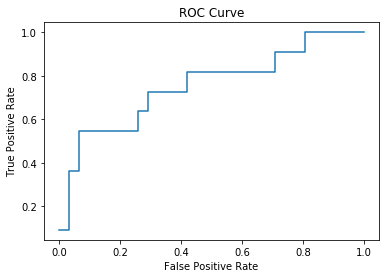

In [88]:
#Plot the ROC Curve
fig = plt.figure()
ax = fig.add_subplot(111)
true_positives, false_positives, _ = roc_curve(res_rf.toPandas()['label'],\
                                    res_rf.toPandas()['probability'].apply(lambda x:x[1]).values)
ax.plot(true_positives, false_positives)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")


In [89]:
# (0.8033039131012418, {Param(parent='RandomForestClassifier_5ae815e89ef9', name='maxDepth', 
#                             doc='Maximum depth of the tree. (>= 0) E.g., 
#                             depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 12, 
#                             Param(parent='RandomForestClassifier_5ae815e89ef9', name='seed', doc='random seed.')
#                             : 24, 
#                             Param(parent='RandomForestClassifier_5ae815e89ef9', 
                                  
#                             name='numTrees', doc='Number of trees to train (>= 1).'): 24})


#Use best parameters to tune our final model
rf = RandomForestClassifier(labelCol="label", 
                            featuresCol="features",
                            maxDepth=12,
                            seed=24,
                            numTrees=24
                            )


f1_eval=MulticlassClassificationEvaluator(metricName = "f1")
param_grid = ParamGridBuilder().build()
rf_cross_validator = CrossValidator(estimator = rf, estimatorParamMaps = param_grid,\
                              evaluator = f1_eval, numFolds = 2)

rf_cv_model = rf_cross_validator.fit(training_data)
rf_cv_model.avgMetrics


[0.8072083719052319]

In [93]:
res_rf = rf_cv_model.transform(test_data)
#Obtain and print evaluation metrics for Random Forest Classifier
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for the final Random Forest Classifier model are:")
print("Accuracy: {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "accuracy"})))
print("F1 Score: {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "f1"})))

The metrics for the final Random Forest Classifier model are:
Accuracy: 0.8095238095238095
F1 Score: 0.7941317941317942


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.